In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from timple.timedelta import strftimedelta
import fastf1 as ff1
import fastf1.plotting as ff1pl
from fastf1.core import Laps
import re
from PIL import Image
import numpy as np

In [2]:
ff1.Cache.enable_cache('../cache')
ff1pl.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False)

In [11]:
year, event, event_type = 2023, 'miami', 'FP2'
session = ff1.get_session(year, event, event_type)
session.load()

core           INFO 	Loading data for Miami Grand Prix - Practice 2 [v2.3.1]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
C:\Users\getou\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dty

In [4]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

['VER' 'RUS' 'SAI' 'HAM' 'OCO' 'HUL' 'ZHO' 'ALB' 'TSU' 'DEV' 'MAG' 'STR'
 'LEC' 'ALO' 'PER' 'GAS' 'NOR' 'SAR' 'BOT' 'PIA']


In [5]:
list_fastest_laps = list()
for drv in drivers:
    drvs_fastest_lap = session.laps.pick_driver(drv).pick_fastest()
    list_fastest_laps.append(drvs_fastest_lap)
fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)

In [7]:
pole_lap = fastest_laps.pick_fastest().dropna()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']].dropna())

   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:27.930000        0 days 00:00:00
1     SAI 0 days 00:01:28.315000 0 days 00:00:00.385000
2     LEC 0 days 00:01:28.398000 0 days 00:00:00.468000
3     PER 0 days 00:01:28.419000 0 days 00:00:00.489000
4     ALO 0 days 00:01:28.660000 0 days 00:00:00.730000
5     NOR 0 days 00:01:28.741000 0 days 00:00:00.811000
6     HAM 0 days 00:01:28.858000 0 days 00:00:00.928000
7     STR 0 days 00:01:28.930000        0 days 00:00:01
8     OCO 0 days 00:01:28.937000 0 days 00:00:01.007000
9     ALB 0 days 00:01:29.046000 0 days 00:00:01.116000
10    GAS 0 days 00:01:29.098000 0 days 00:00:01.168000
11    MAG 0 days 00:01:29.171000 0 days 00:00:01.241000
12    ZHO 0 days 00:01:29.181000 0 days 00:00:01.251000
13    BOT 0 days 00:01:29.189000 0 days 00:00:01.259000
14    RUS 0 days 00:01:29.216000 0 days 00:00:01.286000
15    PIA 0 days 00:01:29.339000 0 days 00:00:01.409000
16    HUL 0 days 00:01:29.393000 0 days 00:00:01

In [14]:
filtered_fastest_laps = fastest_laps.dropna(subset=['Team'])
def lap_time_delta_to_string(delta):
    if pd.isna(delta):
        return ''
    minutes, remainder = divmod(delta.seconds, 60)
    seconds = remainder + delta.microseconds / 1e6
    return f"+{seconds:05.3f}s"

team_colors = list()
for index, lap in filtered_fastest_laps.iterrows():
    color = ff1.plotting.team_color(lap['Team'])
    team_colors.append(color)

modified_fastest_laps = filtered_fastest_laps.copy()

# GAP to Leader
# modified_fastest_laps['LapTimeDeltaString'] = modified_fastest_laps['LapTimeDelta'].apply(lap_time_delta_to_string)

# INTERVALS
modified_fastest_laps['Interval'] = modified_fastest_laps['LapTime'].diff()
modified_fastest_laps['IntervalString'] = modified_fastest_laps['Interval'].apply(lap_time_delta_to_string)

In [17]:
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plot_size = [10, 10]
plot_title = f"{session.event['EventName']} {session.event.year} {event_type} Intervals\n Fastest Lap: {lap_time_string} ({pole_lap['Driver']})"
plot_filename = re.sub(r'\W+', '', plot_title.replace("\n", " ")) + ".png"
logo_path = '../RCKMG_logo.png'
logo_img = Image.open(logo_path)

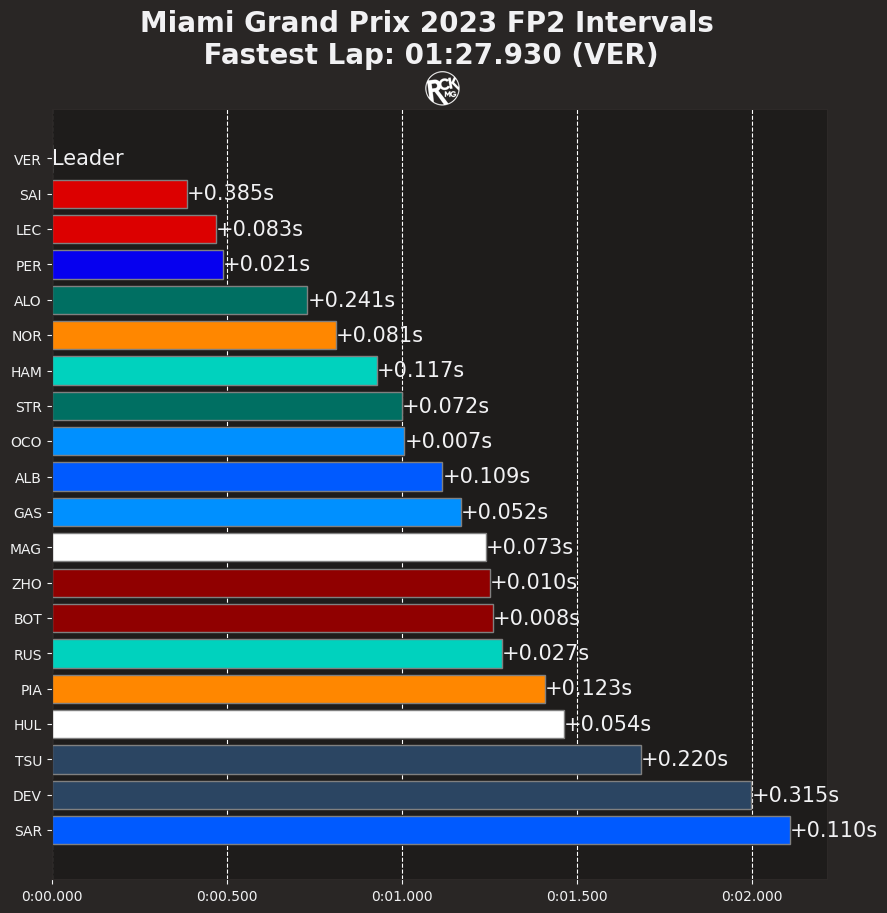

In [18]:
plt.rcParams['figure.figsize'] = plot_size
fig, ax = plt.subplots()
ax.barh(filtered_fastest_laps.index, filtered_fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(filtered_fastest_laps.index)
ax.set_yticklabels(filtered_fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='white', zorder=-1000)
lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(plot_title, size=20, fontweight='bold')

# Add the interval on the bars
for i, rect in enumerate(ax.containers[0]):
    x = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2

    # Display "Leader" for the first bar and interval for the rest
    if i == 0:
        text = "Leader"
    else:
        text = modified_fastest_laps.iloc[i]['IntervalString']

    ax.text(x, y, text, ha='left', va='center', size=15)

# Define the new width and height for the logo
new_width = 35
new_height = 35
# Resize the logo
logo_resized = logo_img.resize((new_width, new_height))
logo_resized_np = np.array(logo_resized)
logo_x = 425
logo_y = 807
fig.figimage(logo_resized_np, xo=logo_x, yo=logo_y, zorder=1, origin='upper', alpha=1)

# Add the gap to the leader on the bars
# bars = ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
#                color=team_colors, edgecolor='grey')
# for i, rect in enumerate(bars[:len(modified_fastest_laps)]):
#     x = rect.get_width()
#     y = rect.get_y() + rect.get_height() / 2
#     gap = modified_fastest_laps.iloc[i]['LapTimeDeltaString']
#     ax.text(x, y, gap, ha='left', va='center', size=15)

plt.show()